# Graph construction

## Load the data

In [13]:
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import constants as c

In [14]:
artists = pkl.load(open('data/artists.pkl', 'rb'))
songs = pkl.load(open('data/songs.pkl', 'rb'))
creations = pkl.load(open('data/creations.pkl', 'rb'))

songs['explicit'] = songs['explicit'].astype(int)

## Construct the graph

In [15]:
import torch_geometric as tg
from torch_geometric.data.hetero_data import HeteroData
import networkx as nx
import torch

Take only some of the artists and their songs

In [73]:
prefix = -1
if prefix > len(artists) or prefix == -1:
    p_artists = artists
else:
    p_artists = artists.sample(n=prefix)
p_artists_ids = p_artists.reset_index()['artist'].reset_index().set_index('artist')

p_creations_ids = creations.loc[creations['artist'].isin(p_artists.index)]
respective_songs = p_creations_ids['song'].unique()
p_songs = songs.loc[respective_songs]
p_songs = p_songs[p_songs['year'] < c.pivot_year]
p_songs_ids = p_songs.reset_index()['song'].reset_index().set_index('song')

p_creations_ids = p_creations_ids.join(p_artists_ids, on='artist', how='left')
p_creations_ids['artist_id'] = p_creations_ids['index']
p_creations_ids = p_creations_ids.drop(columns=['index'])

post_pivot_year = p_creations_ids.join(songs[['year']], on='song', how='left')

p_creations_ids = p_creations_ids[p_creations_ids['song'].isin(p_songs.index)]
p_creations_ids = p_creations_ids.join(p_songs_ids, on='song', how='left')
p_creations_ids['song_id'] = p_creations_ids['index']
p_creations_ids = p_creations_ids.drop(columns=['index'])

Take all the positive pairs and sample same amount of negative pairs

In [74]:
from itertools import combinations
from random import choices
from time import time


def create_n_pairs(artists, n):
    lst = list(zip(choices(artists, k=n), choices(artists, k=n)))
    return [p for p in lst if p[0] != p[1]]


t = time()
post_pivot_year = post_pivot_year[post_pivot_year['year'] >= c.pivot_year]
post_pivot_year = post_pivot_year.groupby('song')[['artist_id']].agg(list)
post_pivot_year['num_artists'] = post_pivot_year['artist_id'].apply(len)
post_pivot_year = post_pivot_year[post_pivot_year['num_artists'] > 1]
positive_pairs = list(set().union(*post_pivot_year['artist_id'].apply(lambda x: list(combinations(x, 2))).tolist()))
pp_len = len(positive_pairs)
print(f"{pp_len * 100 / (len(p_artists_ids) ** 2 - len(p_artists_ids)):0.5f}% ({pp_len}) of all pairs")

negative_pairs = create_n_pairs(p_artists_ids['index'].to_list(), pp_len)

negative_pairs = set(negative_pairs) - set(positive_pairs)
while len(negative_pairs) < pp_len:
    negative_pairs = negative_pairs.union(
        set(create_n_pairs(p_artists_ids['index'].to_list(), pp_len - len(negative_pairs))))
    negative_pairs = set(negative_pairs) - set(positive_pairs)
negative_pairs = list(negative_pairs)
print(f"Time: {time() - t} seconds")

pairs = positive_pairs + negative_pairs
pairs = pd.DataFrame(pairs, columns=['artist_1', 'artist_2'])
pairs['label'] = [1] * pp_len + [0] * pp_len

0.04082% (1) of all pairs
Time: 0.02493429183959961 seconds


In [75]:
def calculate_common_years(row):
    start_year1, end_year1 = int(row['first_year_1']), int(row['last_year_1'])
    start_year2, end_year2 = int(row['first_year_2']), int(row['last_year_2'])
    years_set1 = set(range(start_year1, end_year1 + 1))
    years_set2 = set(range(start_year2, end_year2 + 1))
    return len(years_set1.intersection(years_set2))

In [76]:
artist_pairs = pd.concat([p_artists.loc[p_artists_ids.iloc[pairs['artist_1'], :].index].reset_index(drop=True).rename(
    columns={c: f"{c}_1" for c in p_artists.columns}),
    p_artists.loc[p_artists_ids.iloc[pairs['artist_2'], :].index].reset_index(drop=True).rename(
        columns={c: f"{c}_2" for c in p_artists.columns})]
    , axis=1)

artist_pairs.insert(0, 'intersection_len', artist_pairs.apply(lambda x: calculate_common_years(x), axis=1))
artist_pairs = artist_pairs.drop(
    columns=['first_year_1', 'last_year_1', 'first_year_2', 'last_year_2', 'years_span_1', 'years_span_2',
             'days_span_1', 'days_span_2'])
for col in p_artists.columns[4:]:
    artist_pairs[f"{col}_diff"] = abs(artist_pairs[f"{col}_1"] - artist_pairs[f"{col}_2"])
    artist_pairs = artist_pairs.drop(columns=[f"{col}_1", f"{col}_2"])
artist_pairs

,intersection_len,num_albums_diff,num_songs_diff,avg_songs_per_album_diff,min_duration_ms_diff,max_duration_ms_diff,avg_duration_ms_diff,avg_explicit_diff,avg_danceability_diff,avg_energy_diff,avg_key_diff,avg_loudness_diff,avg_mode_diff,avg_speechiness_diff,avg_acousticness_diff,avg_instrumentalness_diff,avg_liveness_diff,avg_valence_diff,avg_tempo_diff
0,2,11,11,1.3,17653,253440,24953.928571,0.0,0.057333,0.179424,1.52381,7.5165,0.238095,0.00716,0.052214,0.078236,0.134333,0.13594,0.644333
1,0,1,1,0.0,16853,68280,42566.500000,0.0,0.071500,0.169300,0.50000,3.2890,0.000000,0.00220,0.321500,0.473600,0.037750,0.12300,38.597500


In [77]:
pairs_edges = pairs[['artist_1', 'artist_2']].reset_index().melt(id_vars='index')[['value', 'index']]
pairs_edges = pairs_edges.rename(columns={'index': 'pair_id', 'value': 'artist_id'})
pairs_edges

,artist_id,pair_id
0,16,0
1,24,1
2,0,0
3,23,1


In [78]:
torch_creations_ids = torch.tensor(p_creations_ids[['artist_id', 'song_id']].values.T)
torch_artists = torch.tensor(p_artists.values)
torch_songs = torch.tensor(p_songs.values)
torch_pairs = torch.tensor(artist_pairs.values)
torch_pairs_edges = torch.tensor(pairs_edges.values.T)

In [79]:
data = HeteroData(song={'x': torch_songs},
                  artist={'x': torch_artists},
                  pair={'x': torch_pairs, 'y': torch.tensor(pairs['label'])},
                  artist__creates__song={'edge_index': torch_creations_ids},
                  song__createdBy__artist={'edge_index': torch_creations_ids.flip(0)},
                  artist__participants__pair={'edge_index': torch_pairs_edges})
data

HeteroData(
  song={ x=[261, 16] },
  artist={ x=[50, 22] },
  pair={
    x=[2, 19],
    y=[2]
  },
  (artist, creates, song)={ edge_index=[2, 275] },
  (song, createdBy, artist)={ edge_index=[2, 275] },
  (artist, participants, pair)={ edge_index=[2, 4] }
)

Save the data

In [80]:
torch.save(data, 'data/final_graph.pt')

Visualize the graph

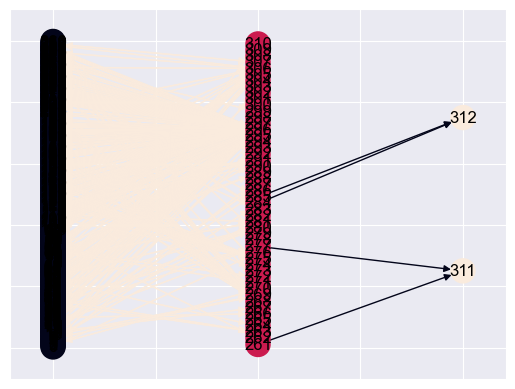

In [81]:
if prefix != -1:
    tdata = data.to_homogeneous()

    counts = [0] * len(tdata.node_type.unique())
    steps = 1 / tdata.node_type.bincount()
    y = []
    for x in tdata.node_type:
        y.append((counts[x] + 0.5) * steps[x])
        counts[x] += 1

    transform = {(0, 1): 5,
                 (1, 2): 2,
                 (1, 0): 5}

    g = tg.utils.to_networkx(tdata)
    edge_color = [transform[(tdata.node_type[a].item(), tdata.node_type[b].item())] for a, b in g.edges]

    nx.draw_networkx(g, node_color=tdata.node_type, edge_color=edge_color,
                     pos={i: (x.item(), y[i]) for i, x in enumerate(tdata.node_type)})